In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from dataclasses import dataclass
from typing import Tuple


from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from itertools import groupby
from operator import itemgetter
import multiprocessing as mp

%load_ext autoreload
%autoreload 2

In [8]:
dfres = pd.read_hdf('../data/simulator/figure/Figure_hws/hws_jan22.h5')

Create Plume Model $\bar{P}(wo|x,y)$

Optimal Parameters:
A = 0.010103599388084136
x0 = 0.0
y0 = 0.0
sigma_y = 0.2
dy = 0.55
dist x = 0.02


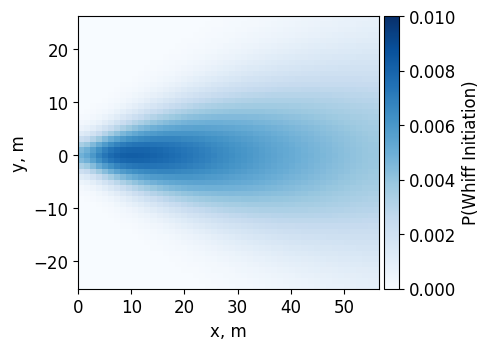

In [9]:
n_bins_x = n_bins_y = 50
heatmap_whiff, xedges, yedges = np.histogram2d(
    dfres['distance_along_streakline'], 
    dfres['nearest_from_streakline'], 
    bins=[n_bins_x, n_bins_y], 
    weights=dfres['whiff_flag']
)

heatmap_total, _, _ = np.histogram2d(
    dfres['distance_along_streakline'], 
    dfres['nearest_from_streakline'], 
    bins=[n_bins_x, n_bins_y]
)

# Calculate empirical probabilities (Equation 1)
with np.errstate(divide='ignore', invalid='ignore'):
    heatmap_prob = np.divide(
        heatmap_whiff, 
        heatmap_total, 
        out=np.zeros_like(heatmap_whiff), 
        where=heatmap_total != 0
    )

# Set up grid for analysis
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Prepare data for optimization
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Filter valid bins
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x):
    distance_x = x - x0
    distance_y = y - y0
    # distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    # Simple sigma_y growth
    sigma_y = base_sigma_y + distance_scale_factor_y * np.power(np.abs(distance_x), 0.8)  # stronger growth with distance
    
    # Basic Gaussian terms
    gaussian_y = np.exp(-(distance_y**2) / (2 * sigma_y**2))
    decay_term_x = np.exp(-decay_factor_x * distance_x)
    
    return A * gaussian_y * decay_term_x

bounds = [
    (0, 1),  # A (amplitude)
    (0, 0),          # x0 fixed
    (0, 0),          # y0 fixed
    (0.2, 5.0),      # base_sigma_y
    (0.55, 2.0),     # distance_scale_factor_y - for gradual spread
    (0.02, 1)        # decay_factor_x
]

# initial_params = [0.01, 0.0, 0.0, 0.1, 1.0, 0.02]
initial_params = [0.5, 0.0, 0.0, 0.1, 0.8, 0.02] 

# Negative log-likelihood function
def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x = params
    p = directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)

# Perform optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_y = {optimal_params[3]}")
print(f"dy = {optimal_params[4]}")
print(f"dist x = {optimal_params[5]}")


# Compute fitted probabilities
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
# After calculating fitted_p
scaling_factor = 1.15  # adjust this value as needed
fitted_p = fitted_p * scaling_factor
fitted_p_heatmap_spatial = fitted_p.reshape((len(x_centers), len(y_centers)))

def smooth_heatmap_adjustment(heatmap, region_mask, adjustment_factor, sigma=1.0):
    # Apply the adjustment to the specified region
    adjusted_heatmap = heatmap.copy()
    adjusted_heatmap[region_mask] *= adjustment_factor
    smoothed_heatmap = gaussian_filter(adjusted_heatmap, sigma=sigma)
    
    return smoothed_heatmap

region_mask = (X_centers > 10) & (X_centers < 15)  # Adjust region between 10m and 15m along the streakline
adjustment_factor = 1  # Reduce probability by 20% in this region
sigma_smoothing = 2  # Narrower smoothing for sharper transitions
smoothed_fitted_p_heatmap = smooth_heatmap_adjustment(
    fitted_p_heatmap_spatial, region_mask, adjustment_factor, sigma=sigma_smoothing
)

# Plot the smoothed adjusted heatmap
f, ax = plt.subplots(1, 1, figsize=(5, 5))
cax = ax.imshow(
    smoothed_fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='P(Whiff Initiation)')
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
# ax.set_title('P(Whiff Initiation)')
mpl_functions.set_fontsize(f,12)
f.tight_layout()

Calculate Empirical Statistics - Whiff and No Whiff Statistics

In [10]:
def avg_distance(df,index,dat): #input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def get_index_nowhiff(data, th):
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index

def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)

    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)

    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(dfres.odor,th)
index_nowhiff = get_index_nowhiff(dfres.odor,th)
fdf = pd.DataFrame()
fdf_nowhiff=pd.DataFrame()

cal_stat(dfres,index,fdf)
avg_distance(dfres, index, fdf)
wc_wsd_nowhiff(dfres, index_nowhiff,fdf_nowhiff)
avg_distance_nowhiff(dfres,index_nowhiff,fdf_nowhiff)